# Previsão de Pedidos — Modelos para SIM Card e Terminal


## Sumário

1. Problema de Negócio
2. Bibliotecas
3. ETL
4. Dicionário de Dados  
5. Descritivo
6. Split Temporal
7. Baselines por Tipo
8. Avaliações
9. PRED
10. Save pipeline e modelos  
11. Implementação
12. Retreino

## 1 - Problema de Negócio

**Contexto:**  
Esse projeto tem como finalidade a criação de modelos de predição de quantidade de pedidos no CD - Belo Horizonte 

# 2 - Bibliotecas

In [10]:
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

from sklearn.metrics import mean_absolute_error
from pandas.tseries.offsets import BusinessDay, MonthEnd

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS


from pathlib import Path
import json, pickle


# 3 - ETL

Resumo da etapa (ETL): Esta célula carrega o Excel (Pedidos.xlsx), valida a existência do arquivo e das colunas obrigatórias, filtra os registros para MG e para os tipos Simcard e Terminal, converte a data (DT NF) e agrega a contagem diária de pedidos por tipo (y). Em seguida, padroniza o calendário em dias úteis (preenchendo lacunas com y=0), cria variáveis exógenas de calendário (dow_num e mes_num) e um indicador de fechamento (1 nos 3 últimos dias úteis de cada mês). Por fim, consolida tudo em Y_df com unique_id, ds, y e as features, preparando a base para o treinamento de modelos 

In [2]:
# ================================
# ETL — Carregamento e Checagens
# ================================
# Caminho do Excel
ARQ_XLSX = r"C:\Users\40418197\Desktop\ML Pedidos\Pedidos.xlsx"

UF_ALVO   = "MG"
TIPOS_OK  = ["Simcard", "Terminal"]
COLS_KEEP = ["DT NF", "TIPO MAT", "MES", "UF"]

# ## 2) Leitura, filtro e preparação (Seg–Sex) + feature `fechamento`

if not os.path.exists(ARQ_XLSX):
    raise FileNotFoundError(f"Não encontrei o arquivo: {ARQ_XLSX}")

# Preserva o bruto (opcional, mas útil)
df_raw = pd.read_excel(ARQ_XLSX, engine="openpyxl")

missing = set(COLS_KEEP) - set(df_raw.columns)
if missing:
    raise ValueError(f"Colunas obrigatórias ausentes no Excel: {missing}")

# Filtra
df = df_raw[COLS_KEEP].copy()
# ✅ Corrige o filtro: use `in` no query e crase na coluna com espaço
df = df.query("UF == @UF_ALVO and `TIPO MAT` in @TIPOS_OK").copy()

# Datas
df["DT NF"] = pd.to_datetime(df["DT NF"])
df["dia"]   = df["DT NF"].dt.floor("D")

# Agrega contagem diária por tipo
daily = (df.groupby(["TIPO MAT","dia"], as_index=False)
           .size().rename(columns={"size":"y"}))

def make_business_series(g):
    """
    - Reindexa em dias úteis (freq='B')
    - Preenche y=0 em dias úteis sem pedido
    - Cria exógenas: dow_num, mes_num
    - Cria 'fechamento' = 1 nos 3 últimos dias úteis do mês
    """
    g = g.set_index("dia").sort_index()
    bidx = pd.date_range(g.index.min(), g.index.max(), freq="B")
    g = g.reindex(bidx)
    g.index.name = "ds"
    g["y"] = g["y"].fillna(0).astype(int)
    g["dow_num"] = g.index.dayofweek   # 0..4 em B-days
    g["mes_num"] = g.index.month

    # fechamento
    g["fechamento"] = 0
    for _, gi in g.groupby(g.index.to_period('M')):
        last3 = gi.index.sort_values()[-3:]
        g.loc[last3, "fechamento"] = 1

    return g.reset_index()

TIPOS_OK = list(TIPOS_OK)  # garante iterável simples
series = {}
for t in TIPOS_OK:
    g = daily[daily["TIPO MAT"]==t][["dia","y"]].copy()
    series[t] = make_business_series(g)
    series[t]["unique_id"] = t

Y_df = pd.concat([series[t] for t in TIPOS_OK], ignore_index=True)[
    ["unique_id","ds","y","dow_num","mes_num","fechamento"]
].sort_values(["unique_id","ds"]).reset_index(drop=True)

print("Período (Business Days) global:", Y_df["ds"].min().date(), "→", Y_df["ds"].max().date())


Período (Business Days) global: 2025-01-02 → 2025-06-25


# 4 - Dicionário de Dados

- **UF**: Estado (Unidade Federativa onde ocorreu o atendimento)
- **TIPO MAT**: Tipo de atendimento do pedido (ex.: instalação, manutenção, reparo)
- **MES**: Mês de referência do atendimento
- **DT NF**: Data do atendimento do pedido (data da nota fiscal)
- **ALVO_SIM**: Variável alvo para o modelo SIM Card (Quantidade de linhas com TIPO MAT == SimCard, cada linha um pedido)
- **ALVO_TERMINAL**: Variável alvo para o modelo Terminal (Quantidade de linhas com TIPO MAT == Terminal, cada linha um pedido)



In [3]:
# Função para gerar dicionário de dados inferido a partir do DataFrame
def gerar_dic_dados(df: pd.DataFrame, sample_cats: int = 10) -> pd.DataFrame:
    d = []
    for col in df.columns:
        s = df[col]
        tipo = str(s.dtype)
        pct_nulos = float(s.isna().mean() * 100)
        unicos = int(s.nunique(dropna=True))

        # Exemplos
        if unicos <= sample_cats:
            vals = s.dropna().unique()[:sample_cats]
            # Formata datas de forma amigável
            if pd.api.types.is_datetime64_any_dtype(s):
                import numpy as np
                exemplos = ", ".join(
                    pd.to_datetime(pd.Series(vals)).dt.strftime("%Y-%m-%d").tolist()
                )
            else:
                exemplos = ", ".join(map(str, vals))
        else:
            exemplos = "muitos valores"

        d.append({
            "coluna": col,
            "dtype_pandas": tipo,
            "%_nulos": round(pct_nulos, 2),
            "n_unicos": unicos,
            "exemplos": exemplos
        })
    return (pd.DataFrame(d)
            .sort_values(by=["%_nulos", "n_unicos"], ascending=[False, True])
            .reset_index(drop=True))

# 🔹 Dicionário do dataset final de modelagem
dic_models = gerar_dic_dados(Y_df)
dic_raw = gerar_dic_dados(df)
# Em notebook, fica mais bonito com Styler:
try:
    display(dic_raw.style.format({"%_nulos": "{:.2f}"}).set_caption("Dicionário de Dados — df"))
    display(dic_models.style.format({"%_nulos": "{:.2f}"}).set_caption("Dicionário de Dados — Y_df"))
except NameError:
    print(dic_raw)
    print(dic_models)

,coluna,dtype_pandas,%_nulos,n_unicos,exemplos
0,UF,object,0.00,1,MG
1,TIPO MAT,object,0.00,2,"Simcard, Terminal"
2,MES,object,0.00,6,"JAN, FEV, MAR, ABR, MAI, JUN"
3,DT NF,datetime64[ns],0.00,133,muitos valores
4,dia,datetime64[ns],0.00,133,muitos valores


,coluna,dtype_pandas,%_nulos,n_unicos,exemplos
0,unique_id,object,0.00,2,"Simcard, Terminal"
1,fechamento,int64,0.00,2,"0, 1"
2,dow_num,int32,0.00,5,"3, 4, 0, 1, 2"
3,mes_num,int32,0.00,6,"1, 2, 3, 4, 5, 6"
4,ds,datetime64[ns],0.00,125,muitos valores
5,y,int64,0.00,228,muitos valores


# 5 - Descritiva

## 5.1 Relação dias próximos ao fechamento do mês com pedidos 


=== Simcard ===
Média fechamento=1: 1478.8 | fechamento=0: 1352.1 | Uplift: 9.4%


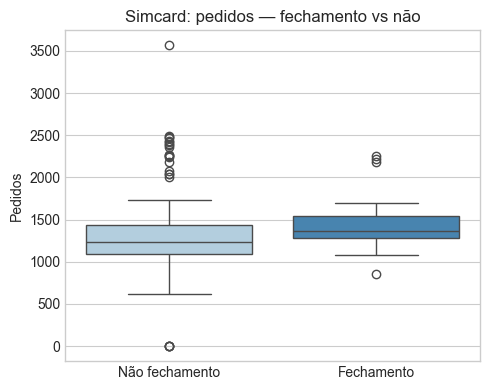


=== Terminal ===
Média fechamento=1: 1398.8 | fechamento=0: 1158.8 | Uplift: 20.7%


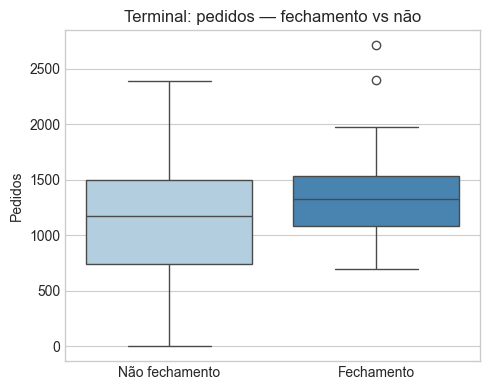

In [4]:
# ## 3) Diagnóstico do `fechamento` (uplift + boxplot)

def visualizar_efeito_fechamento(Y):
    for uid in Y["unique_id"].unique():
        g = Y[Y["unique_id"]==uid]
        base = g.groupby("fechamento")["y"].mean()
        mean_f = base.get(1, np.nan)
        mean_n = base.get(0, np.nan)
        uplift = (mean_f - mean_n) / mean_n * 100 if (isinstance(mean_n, (int,float)) and mean_n>0) else np.nan

        print(f"\n=== {uid} ===")
        print(f"Média fechamento=1: {mean_f:.1f} | fechamento=0: {mean_n:.1f} | Uplift: {uplift:.1f}%")

        plt.figure(figsize=(5,4))
        sns.boxplot(x=g["fechamento"].map({0:"Não fechamento",1:"Fechamento"}), y=g["y"], palette="Blues")
        plt.title(f"{uid}: pedidos — fechamento vs não")
        plt.xlabel(""); plt.ylabel("Pedidos"); plt.tight_layout(); plt.show()

visualizar_efeito_fechamento(Y_df)

## 5.2 Séries temporais por tipo de pedido

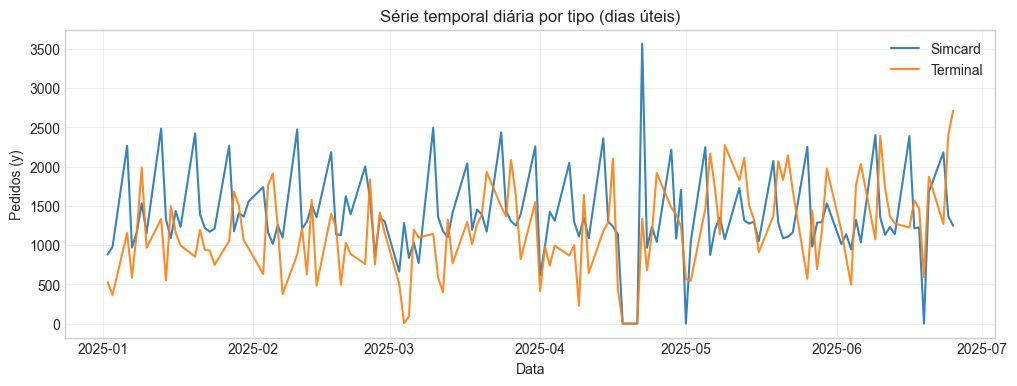

In [14]:

fig, ax = plt.subplots(figsize=(12,4))
for t, g in Y_df.groupby('unique_id'):
    ax.plot(g['ds'], g['y'], label=t, alpha=0.9)
ax.set_title('Série temporal diária por tipo (dias úteis)')
ax.set_xlabel('Data'); ax.set_ylabel('Pedidos (y)')
ax.legend(); ax.grid(True, alpha=0.3)
plt.show()


# 6 - Split Temporal

Aqui definimos a estratégia de separação entre treino e teste respeitando a ordem temporal, essencial para séries temporais. Primeiro, configuramos hiperparâmetros como o tamanho da janela de entrada para cada tipo (INPUT_SIZE_SIM e INPUT_SIZE_TER), o horizonte de previsão (H = 1, ou seja, prever o próximo dia útil) e o tamanho do conjunto de teste (TEST_BDAYS = 16 dias úteis finais). Em seguida, dividimos o dataset Y_df em treino (todos os dias úteis exceto os últimos 16) e teste (os últimos 16 dias úteis), garantindo que não haja vazamento de informação futura. Por fim, criamos uma função para obter os splits por unique_id (Simcard e Terminal) e exibimos os intervalos de datas para cada série.



In [ ]:
# Split temporal — treino/teste (últimos N dias úteis)

# Hiperparâmetros e splits
INPUT_SIZE_SIM = 35     # janela Simcard (~5 semanas úteis)
INPUT_SIZE_TER = 84     # janela Terminal (mais longa)
H = 1                   # horizonte D+1 (próximo dia útil)
TEST_BDAYS = 16         # últimos N dias úteis para teste

all_bd = np.sort(Y_df["ds"].unique())
test_dates = all_bd[-TEST_BDAYS:] if len(all_bd) > TEST_BDAYS else all_bd

train = Y_df[~Y_df["ds"].isin(test_dates)].copy()
test  = Y_df[Y_df["ds"].isin(test_dates)].copy()

def split_by_uid(uid):
    tr = train[train["unique_id"]==uid].copy()
    te = test [test ["unique_id"]==uid].copy()
    return tr, te

for t in TIPOS_OK:
    tr, te = split_by_uid(t)
    print(f"{t:9s} | Treino: {tr['ds'].min().date()} → {tr['ds'].max().date()} | Teste: {te['ds'].min().date()} → {te['ds'].max().date()}")

Simcard   | Treino: 2025-01-02 → 2025-06-03 | Teste: 2025-06-04 → 2025-06-25
Terminal  | Treino: 2025-01-02 → 2025-06-03 | Teste: 2025-06-04 → 2025-06-25


# 7 - Baselines por tipo

 Aqui criamos e avaliamos modelos de referência simples para cada tipo de material (Simcard e Terminal), que servem como benchmark para comparar modelos mais sofisticados. Foram implementadas duas estratégias:

Mean DOW: prevê a demanda usando a média histórica do mesmo dia da semana.

Same DOW (últimas 4 semanas úteis): usa a média dos últimos dias úteis com o mesmo dia da semana, dentro de uma janela de 4 semanas (~20 dias úteis).

As previsões são avaliadas com MAE, sMAPE e acurácia por faixas (agrupando valores em bins de 200 unidades), fornecendo métricas para entender a qualidade mínima aceitável antes de aplicar modelos mais complexos.

In [ ]:
# Baselines por tipo (Seg–Sex)

# === Faixas (lotes) ===
BIN_SIZE = 200          # <<-- definido para 200

def to_bin_index_centered(y, bin_size=200):
    """Índice de faixa via arredondamento para o múltiplo de BIN_SIZE mais próximo."""
    y = np.maximum(0, np.asarray(y))
    return np.floor((y + bin_size/2) / bin_size).astype(int)

def acc_bins_centered(y_true, y_pred, bin_size=200):
    """Acurácia Top‑1 em faixas centralizadas (BIN_SIZE)."""
    true_idx = to_bin_index_centered(y_true, bin_size)
    pred_idx = to_bin_index_centered(y_pred, bin_size)
    return (true_idx == pred_idx).mean(), true_idx, pred_idx

def smape(y, yhat, eps=1e-6):
    y, yhat = np.asarray(y), np.asarray(yhat)
    return 100.0 * np.mean(2.0*np.abs(yhat - y) / (np.abs(y) + np.abs(yhat) + eps))

def baseline_dow_mean_per_uid(tr, te):
    means = tr.groupby("dow_num")["y"].mean().to_dict()
    out = te.copy()
    out["yhat_dow_mean"] = out["dow_num"].map(means).fillna(tr["y"].mean())
    return out

def baseline_same_dow_last_4w_B(tr, te, bdays=20):
    out = []
    all_df = pd.concat([tr, te]).sort_values("ds").set_index("ds")
    for ds, row in te.set_index("ds").iterrows():
        dow = int(row["dow_num"])
        ini = ds - BusinessDay(bdays)
        hist = all_df.loc[(all_df.index >= ini) & (all_df.index < ds)]
        hist = hist[hist["dow_num"]==dow]
        yhat = hist["y"].mean() if len(hist) else all_df["y"].mean()
        out.append({"ds":ds, "y":row["y"], "yhat_same_dow_4w":yhat, "dow_num":dow})
    return pd.DataFrame(out).sort_values("ds")

def eval_baselines(uid):
    tr, te = split_by_uid(uid)
    b1 = baseline_dow_mean_per_uid(tr, te)
    b2 = baseline_same_dow_last_4w_B(tr, te, bdays=20)

    print(f"\n=== Baselines — {uid} ===")
    mae = mean_absolute_error(b1["y"], b1["yhat_dow_mean"])
    sm  = smape(b1["y"], b1["yhat_dow_mean"])
    acc, _, _ = acc_bins_centered(b1["y"], b1["yhat_dow_mean"], BIN_SIZE)
    print(f"Mean DOW                 | MAE={mae:.1f} | sMAPE={sm:.2f}% | acc_faixa({BIN_SIZE})={acc*100:.1f}%")

    mae = mean_absolute_error(b2["y"], b2["yhat_same_dow_4w"])
    sm  = smape(b2["y"], b2["yhat_same_dow_4w"])
    acc, _, _ = acc_bins_centered(b2["y"], b2["yhat_same_dow_4w"], BIN_SIZE)
    print(f"Same DOW (≈4 sem úteis)  | MAE={mae:.1f} | sMAPE={sm:.2f}% | acc_faixa({BIN_SIZE})={acc*100:.1f}%")

for t in TIPOS_OK:
    eval_baselines(t)


=== Baselines — Simcard ===
Mean DOW                 | MAE=224.4 | sMAPE=22.14% | acc_faixa(200)=43.8%
Same DOW (≈4 sem úteis)  | MAE=259.7 | sMAPE=24.58% | acc_faixa(200)=37.5%

=== Baselines — Terminal ===
Mean DOW                 | MAE=597.8 | sMAPE=42.03% | acc_faixa(200)=6.2%
Same DOW (≈4 sem úteis)  | MAE=509.5 | sMAPE=35.21% | acc_faixa(200)=12.5%


# 7 - Treino N-HITS

Para cada tipo (Simcard e Terminal), treinamos um modelo N‑HiTS (via NeuralForecast) em dias úteis (freq='B') com horizonte D+1 (H=1), usando janelas de entrada específicas (input_size: 35 e 84), escalonamento robusto e dropout conforme o dicionário cfg. O modelo incorpora exógenas futuras (dow_num, mes_num, fechamento) para capturar padrões de calendário e o efeito de fechamento do mês. Cada modelo é ajustado apenas com o conjunto de treino e armazenado em forecasters[uid] para gerar previsões por tipo no próximo dia útil.

In [ ]:
# Treino — **um N‑HiTS por tipo** (freq='B', com `fechamento`)
cfg = {
    "Simcard":  dict(input_size=INPUT_SIZE_SIM, max_steps=500, dropout=0.05),
    "Terminal": dict(input_size=INPUT_SIZE_TER, max_steps=900, dropout=0.10),
}

forecasters = {}

for uid in TIPOS_OK:
    tr, _ = split_by_uid(uid)
    model = NHITS(
        input_size=cfg[uid]["input_size"],
        h=H,
        max_steps=cfg[uid]["max_steps"],
        batch_size=32,
        scaler_type='robust',
        dropout_prob_theta=cfg[uid]["dropout"],
        futr_exog_list=["dow_num","mes_num","fechamento"],
    )
    nf = NeuralForecast(models=[model], freq='B')
    nf.fit(df=tr[["unique_id","ds","y","dow_num","mes_num","fechamento"]])
    forecasters[uid] = nf

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.6 M  | train
-------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.271    Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.8 M  | train
-------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.380    Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=900` reached.


# 8 - Avaliações

Para cada tipo (Simcard, Terminal), geramos previsões no conjunto de teste com o N‑HiTS já treinado (usando as exógenas dow_num, mes_num, fechamento), unimos com os valores reais e calculamos as métricas MAE, sMAPE e acurácia por faixas (bins de BIN_SIZE=200) — primeiro sem calibração e depois com calibração global opcional, na qual estimamos um viés aditivo nos primeiros CALIB_DAYS dias do teste e ajustamos as previsões (yhat_cal = yhat + bias). Por fim, guardamos para cada uid o DataFrame de predições (com y, yhat, yhat_cal) e o viés estimado, permitindo comparar desempenho bruto vs calibrado e verificar se há tendência sistemática de sub/ super‑previsão.

In [ ]:
# Avaliação no teste — contínuo, faixas (BIN=200) e **calibração global** (opcional)
results = {}
# Calibração global: nº de primeiros dias do teste usados para estimar viés (0 = desativa)
CALIB_DAYS = 5

for uid in TIPOS_OK:
    tr, te = split_by_uid(uid)
    nf = forecasters[uid]

    futr = te[["unique_id","ds","dow_num","mes_num","fechamento"]]
    pred = nf.predict(futr_df=futr).merge(te[["ds","y","unique_id"]], on=["unique_id","ds"], how="left")
    pred.rename(columns={"NHITS":"yhat"}, inplace=True)

    # Sem calibração
    mae0 = mean_absolute_error(pred["y"], pred["yhat"])
    sm0  = smape(pred["y"], pred["yhat"])
    acc0, _, _ = acc_bins_centered(pred["y"], pred["yhat"], BIN_SIZE)

    print(f"\n=== {uid} — Teste (sem calibração) ===")
    print(f"MAE={mae0:.1f} | sMAPE={sm0:.2f}% | Acurácia_faixa({BIN_SIZE})={acc0*100:.1f}%")

    # Calibração global nos primeiros CALIB_DAYS do teste
    bias = 0.0
    if CALIB_DAYS > 0 and len(pred) >= CALIB_DAYS:
        cal_win = pred.sort_values("ds").head(CALIB_DAYS)
        bias = calibrate_bias_on_window(cal_win["y"].values, cal_win["yhat"].values)

        pred["yhat_cal"] = pred["yhat"] + bias
        mae1 = mean_absolute_error(pred["y"], pred["yhat_cal"])
        sm1  = smape(pred["y"], pred["yhat_cal"])
        acc1, _, _ = acc_bins_centered(pred["y"], pred["yhat_cal"], BIN_SIZE)

        print(f"=== {uid} — Teste (com calibração, janela={CALIB_DAYS}) ===")
        print(f"MAE={mae1:.1f} | sMAPE={sm1:.2f}% | Acurácia_faixa({BIN_SIZE})={acc1*100:.1f}%")
    else:
        pred["yhat_cal"] = pred["yhat"]

    results[uid] = dict(pred=pred, bias=bias)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



=== Simcard — Teste (sem calibração) ===
MAE=121.8 | sMAPE=12.11% | Acurácia_faixa(200)=100.0%


Predicting: |          | 0/? [00:00<?, ?it/s]


=== Terminal — Teste (sem calibração) ===
MAE=83.8 | sMAPE=18.40% | Acurácia_faixa(200)=100.0%


# 9 - PRED

Para cada tipo (Simcard, Terminal), geramos a previsão do próximo dia útil (D+1) a partir do treino (make_future_dataframe(h=1)), recalculando as exógenas (dow_num, mes_num, fechamento) para a data futura. O modelo N-HiTS fornece yhat e aplicamos, se disponível, a calibração global (viés aditivo estimado na validação) para obter yhat_cal. Em seguida, ambas as previsões são mapeadas para faixas centralizadas de tamanho BIN=200 por meio de to_bin_index_centered e bin_label_from_idx, produzindo faixa e faixa_cal (ex.: “0–199”, “200–399”). Por fim, consolidamos tudo em prev_all com a previsão D+1 por unique_id, já pronta para consumo operacional (valor pontual e faixa).



In [ ]:
# Previsão D+1 corrigida (usa treino) + faixa (BIN=200) com/sem calibração

def bin_label_from_idx(idx, bin_size=200):
    a = int(idx * bin_size)
    b = int((idx + 1) * bin_size - 1)
    return f"{a}–{b}"

def is_business_month_end_last3(ds):
    """1 se 'ds' for um dos 3 últimos dias úteis do mês; 0 caso contrário."""
    ds = pd.to_datetime(ds).floor("D")
    mstart = ds.replace(day=1)
    mend = (mstart + MonthEnd(1))
    bidx = pd.bdate_range(mstart, mend, freq="B")
    if len(bidx) == 0:
        return 0
    last3 = set(bidx[-3:])
    return int(ds in last3)

def predict_next_business_day(uid, train_df, nf, bias_shift=0.0):
    """
    Prevê D+1 (próximo Business Day) para 'uid' com exógenas e calibração global (bias_shift).
    IMPORTANTE: futr_df a partir do **treino** para evitar inconsistências de timeline.
    """
    tr_u_core = train_df[train_df["unique_id"]==uid][["unique_id","ds","y"]].copy()

    futr = nf.make_future_dataframe(df=tr_u_core, h=1)
    futr["dow_num"]    = futr["ds"].dt.dayofweek
    futr["mes_num"]    = futr["ds"].dt.month
    futr["fechamento"] = futr["ds"].apply(is_business_month_end_last3).astype(int)

    out = nf.predict(futr_df=futr)[["unique_id","ds","NHITS"]].rename(columns={"NHITS":"yhat"})
    out["yhat_cal"] = out["yhat"] + bias_shift

    # Faixas centralizadas (BIN=200)
    idx0 = to_bin_index_centered(out["yhat"].values, BIN_SIZE)[0]
    idx1 = to_bin_index_centered(out["yhat_cal"].values, BIN_SIZE)[0]
    out["faixa"]     = bin_label_from_idx(idx0, BIN_SIZE)
    out["faixa_cal"] = bin_label_from_idx(idx1, BIN_SIZE)
    return out

prev_rows = []
for uid in TIPOS_OK:
    tr, _ = split_by_uid(uid)
    nf = forecasters[uid]
    bias = results[uid]["bias"]
    prev_rows.append(predict_next_business_day(uid, train, nf, bias_shift=bias))

prev_all = pd.concat(prev_rows, ignore_index=True)
print(f"\nPrevisão D+1 (faixas={BIN_SIZE}, com calibração opcional):")
display(prev_all)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]


Previsão D+1 (faixas=200, com calibração opcional):


,unique_id,ds,yhat,yhat_cal,faixa,faixa_cal
0,Simcard,2025-06-04,1066.765137,1066.765137,1000–1199,1000–1199
1,Terminal,2025-06-04,413.244995,413.244995,400–599,400–599


# 10 - Save Pipeline e Modelos

Aqui consolidamos todo o pipeline para reuso e produção. Criamos um diretório único (pipeline/<RUN_ID>) com base na UF e timestamp, e salvamos:

Modelos treinados (forecasters) em formato pickle, um arquivo por tipo (Simcard.pkl, Terminal.pkl).
Configurações essenciais (config.json), incluindo parâmetros do split, calibração, BIN_SIZE, hiperparâmetros (cfg_modelos) e metadados do pipeline.
Esse passo garante reprodutibilidade, facilita deploy e permite carregar modelos e configs rapidamente para previsões futuras sem retrain.

In [11]:
# ## Salvar pipeline (modelos + configs)

RUN_ID = f"{UF_ALVO}_{pd.Timestamp.today().strftime('%Y-%m-%d_%H%M')}"
BASE_DIR = Path("pipeline") / RUN_ID
BASE_DIR.mkdir(parents=True, exist_ok=True)

# Salva modelos (um por tipo)
for uid, nf in forecasters.items():
    with open(BASE_DIR / f"{uid}.pkl", "wb") as f:
        pickle.dump(nf, f)

# Salva configs essenciais
config = {
    "UF_ALVO": UF_ALVO,
    "TIPOS_OK": TIPOS_OK,
    "BIN_SIZE": BIN_SIZE,
    "H": H,
    "TEST_BDAYS": TEST_BDAYS,
    "CALIB_DAYS": CALIB_DAYS,
    "cfg_modelos": cfg
}
with open(BASE_DIR / "config.json", "w", encoding="utf-8") as f:
    json.dump(config, f, indent=2, ensure_ascii=False)


# 11 - Implementação

Esta implementação operacionaliza o pipeline: mantém um repositório de runtime em CSV (history.csv para valores reais por unique_id, ds, y e preds_log.csv para previsões com timestamp e run_dir), oferece utilitários para registrar o histórico do dia e logar previsões, e usa um viés calibrável via EWMA para corrigir tendência do modelo ao longo do tempo. A função predict_next_bday_for_all_uids carrega pipeline (config, modelos, biases), usa o histórico local mais recente como contexto, gera as exógenas de calendário para D+1 (dia útil seguinte), prevê com o modelo, aplica o bias e classifica a previsão em faixas (BIN=200), salvando tudo no log. Já o fluxo eod_submit_and_predict realiza o EOD: grava os reais do dia, atualiza o bias por UID se houver previsão logada para a mesma data (corrigindo o erro com EWMA) e gera a previsão D+1 com saída amigável (valor calibrado e faixa), deixando o sistema pronto para operação diária e aprendizado contínuo.

In [ ]:
# ================================
# PRODUÇÃO — EOD + D+1 + LOGS CSV
# ================================

# --- Caminhos de runtime (CSV) ---
RUNTIME_DIR = Path("runtime_store")
RUNTIME_DIR.mkdir(exist_ok=True)

HIST_PATH = RUNTIME_DIR / "history.csv"     # histórico agregado (unique_id, ds, y)
PRED_LOG  = RUNTIME_DIR / "preds_log.csv"   # log de previsões (unique_id, ds, yhat, yhat_cal, ...)

# --- Utilidades de CSV ---
def load_history():
    if HIST_PATH.exists():
        return pd.read_csv(HIST_PATH, parse_dates=["ds"])
    return pd.DataFrame(columns=["unique_id","ds","y"])

def append_history_row(ds, values: dict):
    """
    Registra os valores reais do dia.
    values = {'Simcard': y_real, 'Terminal': y_real}
    """
    ds = pd.to_datetime(ds).floor("D")
    rows = [{"unique_id": uid, "ds": ds, "y": float(v)} for uid, v in values.items()]
    df_new = pd.DataFrame(rows)
    df_old = load_history()
    df_all = (pd.concat([df_old, df_new], ignore_index=True)
                .drop_duplicates(subset=["unique_id","ds"], keep="last")
                .sort_values(["unique_id","ds"]))
    df_all.to_csv(HIST_PATH, index=False)

def append_pred_log(df_preds):
    """
    Salva/atualiza log de previsões.
    df_preds: ['unique_id','ds','yhat','yhat_cal','faixa','faixa_cal','run_dir']
    """
    df_preds = df_preds.copy()
    df_preds["ts_logged"] = pd.Timestamp.now()
    if PRED_LOG.exists():
        old = pd.read_csv(PRED_LOG, parse_dates=["ds","ts_logged"])
        out = (pd.concat([old, df_preds], ignore_index=True)
                 .drop_duplicates(subset=["unique_id","ds","run_dir"], keep="last"))
    else:
        out = df_preds
    out.to_csv(PRED_LOG, index=False)

# --- Bias (calibração global simples) ---
def update_bias_ewma(old_bias: float, error: float, alpha: float = 0.3) -> float:
    """EWMA do viés: novo = (1-alpha)*antigo + alpha*(erro do dia)."""
    if pd.isna(old_bias):
        old_bias = 0.0
    return float((1 - alpha) * old_bias + alpha * error)

# --- Previsão D+1 usando o histórico local como contexto ---
def predict_next_bday_for_all_uids(pipeline_dir=None, history_df=None, return_all_cols=False, verbose=False):
    """
    - Carrega pipeline (config, modelos, biases).
    - Usa o histórico (tail) como df de contexto para o nf.predict.
    - Preve o próximo dia útil (D+1) para cada UID.
    - Loga as previsões em preds_log.csv.
    """
    config, models, biases, run_dir = load_pipeline(pipeline_dir)
    BIN_SIZE = int(config.get("BIN_SIZE", BIN_SIZE_DEFAULT))

    hist = load_history() if history_df is None else history_df.copy()
    if hist.empty:
        raise ValueError("Histórico vazio. Registre pelo menos um dia de valores reais antes de prever D+1.")

    out_rows = []

    for uid in config["TIPOS_OK"]:
        g = hist[hist["unique_id"]==uid].dropna(subset=["y"]).sort_values("ds")
        if g.empty:
            raise ValueError(f"Sem histórico para UID '{uid}'. Registre valores reais primeiro.")

        last_ds = pd.to_datetime(g["ds"].max()).floor("D")
        ds_next = ensure_business_day(last_ds + BusinessDay(1))

        # Definir janela mínima (usa input_size do modelo, com folga)
        input_size = int(config.get("cfg_modelos", {}).get(uid, {}).get("input_size", 32))
        g_tail = g.iloc[-max(input_size, 40):].copy()

        # Exógenas para histórico e 1 passo futuro
        df_hist_exog = add_exogs(g_tail[["unique_id","ds","y"]])
        futr_next = add_exogs(pd.DataFrame({"unique_id":[uid], "ds":[ds_next]}))

        nf = models[uid]
        pred = nf.predict(
            df=df_hist_exog[["unique_id","ds","y","dow_num","mes_num","fechamento"]],
            futr_df=futr_next[["unique_id","ds","dow_num","mes_num","fechamento"]]
        )

        # Detecta a coluna do modelo (ex.: 'NHITS') e padroniza
        pred_col = next(c for c in pred.columns if c not in ["unique_id","ds"])
        pred = pred.rename(columns={pred_col:"yhat"}).sort_values("ds")

        # Aplica bias e bins
        bias = float(biases.get(uid, 0.0))
        pred["yhat_cal"] = pred["yhat"] + bias
        idx0 = to_bin_index_centered(pred["yhat"].values, BIN_SIZE)[0]
        idx1 = to_bin_index_centered(pred["yhat_cal"].values, BIN_SIZE)[0]
        pred["faixa"]     = bin_label_from_idx(idx0, BIN_SIZE)
        pred["faixa_cal"] = bin_label_from_idx(idx1, BIN_SIZE)

        if return_all_cols:
            pred = pred.merge(futr_next, on=["unique_id","ds"], how="left")

        pred["run_dir"] = str(run_dir)
        out_rows.append(pred)

        if verbose:
            print(f"{uid}: D+1 {ds_next.date()} → {pred['yhat_cal'].iloc[0]:.0f} (faixa {pred['faixa_cal'].iloc[0]})")

    result = (pd.concat(out_rows, ignore_index=True)
                .sort_values(["unique_id","ds"])
                .reset_index(drop=True))

    # Loga previsões D+1
    append_pred_log(result[["unique_id","ds","yhat","yhat_cal","faixa","faixa_cal","run_dir"]])

    return result

# --- EOD: registrar real, atualizar bias (se houver previsão logada), prever D+1 ---
def eod_submit_and_predict(ds_real, real_simcard, real_terminal, alpha_bias=0.3, pipeline_dir=None):
    """
    Fluxo diário:
      1) Registra o real do dia em history.csv.
      2) Se houver previsão logada para este dia em preds_log.csv, atualiza o bias por UID.
      3) Preve D+1 para cada UID usando o histórico local como contexto.
    Retorna DataFrame com a previsão D+1 calibrada.
    """
    ds_real = pd.to_datetime(ds_real).floor("D")

    # 1) Registrar histórico do dia
    append_history_row(ds_real, {"Simcard": real_simcard, "Terminal": real_terminal})

    # 2) Atualizar bias, se houver previsão do dia no log
    config, models, biases, run_dir = load_pipeline(pipeline_dir)
    if PRED_LOG.exists():
        log = pd.read_csv(PRED_LOG, parse_dates=["ds"])
        todays = log[log["ds"] == ds_real]
        if not todays.empty:
            y_true_map = {"Simcard": float(real_simcard), "Terminal": float(real_terminal)}
            new_biases = {}
            for uid in config["TIPOS_OK"]:
                row = todays[todays["unique_id"]==uid]
                if not row.empty:
                    yhat_cal = float(row["yhat_cal"].iloc[0])
                    err = y_true_map[uid] - yhat_cal
                    old = float(biases.get(uid, 0.0))
                    new_biases[uid] = update_bias_ewma(old, err, alpha_bias)
                else:
                    new_biases[uid] = float(biases.get(uid, 0.0))
            # Salva biases atualizados
            with open(Path(run_dir) / "biases.json", "w", encoding="utf-8") as f:
                json.dump(new_biases, f, ensure_ascii=False, indent=2)

    # 3) Prever D+1
    prev_next = predict_next_bday_for_all_uids(pipeline_dir=run_dir, verbose=True)

    # Print amigável solicitado
    for _, row in prev_next.iterrows():
        print(f"{row['unique_id']}: {row['yhat_cal']:.0f} pedidos (faixa {row['faixa_cal']}) — {row['ds'].date()}")

    return prev_next

# ===== Exemplos de uso (modo notebook) =====
# 1) Ao fim do dia, informar os reais e obter a previsão de D+1:
# prev_next = eod_submit_and_predict("2025-10-01", real_simcard=980, real_terminal=2150, alpha_bias=0.3)
# display(prev_next)

# 2) A qualquer momento (sem enviar real agora), prever D+1 baseado no histórico atual:
# prev = predict_next_bday_for_all_uids(verbose=True)
# display(prev)

# 12 - Retreino

Esta rotina recarrega o pipeline atual (configurações, UIDs e viés), lê o histórico local (history.csv), gera as exógenas de calendário (dow_num, mes_num, fechamento) e re-treina um N‑HiTS por tipo usando os mesmos hiperparâmetros definidos em config (incluindo input_size, max_steps, dropout e freq='B' com horizonte H). Ao final, cria um novo diretório versionado (pipeline/<RUN_ID>), salva os modelos treinados (.pkl), a configuração (config.json) e os biases (mantidos ou zerados conforme keep_bias), retornando o caminho do novo pipeline — pronto para uso em produção sem precisar reprocessar toda a ETL.

In [ ]:
# ==========================
# RE-TREINO SOB DEMANDA (ST)
# ==========================
def retrain_from_history(pipeline_dir=None, history_path=HIST_PATH, keep_bias=True):
    # Carrega config & biases do pipeline atual
    config, _, biases, run_dir_old = load_pipeline(pipeline_dir)
    TIPOS = config["TIPOS_OK"]
    H     = int(config.get("H", 1))

    # Lê histórico e cria exógenas
    hist = pd.read_csv(history_path, parse_dates=["ds"]) if Path(history_path).exists() else pd.DataFrame()
    hist = hist[hist["unique_id"].isin(TIPOS)].copy()
    if hist.empty:
        raise ValueError("Histórico vazio — não há como re-treinar.")
    hist = hist.sort_values(["unique_id","ds"])
    hist = add_exogs(hist)

    # Treina NHITS por UID
    forecasters = {}
    for uid in TIPOS:
        params = config["cfg_modelos"][uid]
        model = NHITS(
            input_size=params["input_size"],
            h=H,
            max_steps=params["max_steps"],
            batch_size=32,
            scaler_type='robust',
            dropout_prob_theta=params.get("dropout", 0.0),
        )
        nf = NeuralForecast(models=[model], freq='B')
        df_u = hist[hist["unique_id"]==uid][["unique_id","ds","y","dow_num","mes_num","fechamento"]]
        if df_u.empty:
            raise ValueError(f"Histórico vazio para {uid}.")
        nf.fit(df=df_u)
        forecasters[uid] = nf

    # Salva novo pipeline
    RUN_ID = f"{config['UF_ALVO']}_{pd.Timestamp.today().strftime('%Y-%m-%d_%H%M')}"
    NEW_DIR = Path("pipeline") / RUN_ID
    NEW_DIR.mkdir(parents=True, exist_ok=True)

    # Modelos
    for uid, nf in forecasters.items():
        with open(NEW_DIR / f"{uid}.pkl", "wb") as f:
            pickle.dump(nf, f)

    # Config (mantém igual ao atual)
    with open(NEW_DIR / "config.json", "w", encoding="utf-8") as f:
        json.dump(config, f, ensure_ascii=False, indent=2)

    # Biases: mantém ou zera
    out_biases = biases if keep_bias else {uid: 0.0 for uid in TIPOS}
    with open(NEW_DIR / "biases.json", "w", encoding="utf-8") as f:
        json.dump(out_biases, f, ensure_ascii=False, indent=2)

    print(f"✅ Re-treino concluído. Novo pipeline: {NEW_DIR}")
    return str(NEW_DIR)

# ===== Exemplo manual (rodar 1x por semana) =====
# new_dir = retrain_from_history(keep_bias=True)
# print(new_dir)